# GSL Uruguay - Jan 2020

# Week 4 - FinTech

-----

### This is final week of class and the goal is the consolidate our learning

1. As our final exercise, we will look at the FinTech space and understand the dynamics of online loan lending
2. We use data from LendingClub - an online peer-to-peer loan company
3. Borrowers can get unsecured loans form USD 1,000 to USD 40,000 (UYU 40,000 to UYU 1,500,000)
4. The standard loan period is three years. 
5. Investors can search and browse the loan listings on LendingClub website
    1. They select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. 
6. Investors make money from interest. 
7. LendingClub makes money by charging borrowers an origination fee and investors a service fee.

-----

# About the data

Source: https://www.kaggle.com/wordsforthewise/lending-club

1. Complete loan data for all loans issued through the 2007-2018
2. There are separate files for accepted and rejected loans
3. The accepted loans also include the FICO scores

----

# Setup

## Import libraries

In [100]:
# =====================================================
# python libraries
# =====================================================

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
from scipy import stats

# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# dimension reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed  
import multiprocessing

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

/home/software/sloan/local/lib/py36/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
# =====================================================
# global parameters
# =====================================================

# set working directory
os.chdir("/pool001/madhavk/gsl-uruguay/W-04-FinTech/")

# viewing options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999    
pd.options.display.max_colwidth = 250

#To plot figs on jupyter
%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 14,6

In [6]:
os.listdir("data/")

['raw',
 'accepted_2007_to_2018Q4.csv',
 'rejected_2007_to_2018Q4.csv',
 'lending-club-data-dictionary.csv']

----

# 1. Import data

## 1.1. Accepted applications

In [7]:
acc = pd.read_csv("data/accepted_2007_to_2018Q4.csv")
print(acc.shape)

(2260701, 151)


In [8]:
display(acc.head())

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68407277,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68355089,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300

In [9]:
list(acc.columns)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

In [10]:
col_names = list(acc.columns)
col_names.sort()
col_names

['acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'disbursement_method',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'home_ownership',
 'id',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_credit_pull_

In [11]:
# dependent variable
acc["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [12]:
# remove cases with missing amount
print(acc.shape)
acc = acc.loc[pd.notnull(acc["loan_amnt"]), :]
print(acc.shape)

(2260701, 151)
(2260668, 151)


----

## 1.2. Variable descriptions

In [13]:
data_dict = pd.read_csv("data/lending-club-data-dictionary.csv")
print(data_dict.shape)

(151, 2)


In [14]:
data_dict

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


----

## 1.3. Rejected applications

In [15]:
rej = pd.read_csv("data/rejected_2007_to_2018Q4.csv")
print(rej.shape)

(27648741, 9)


In [16]:
display(rej.head())

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


----

# 2. Exploratory data analysis

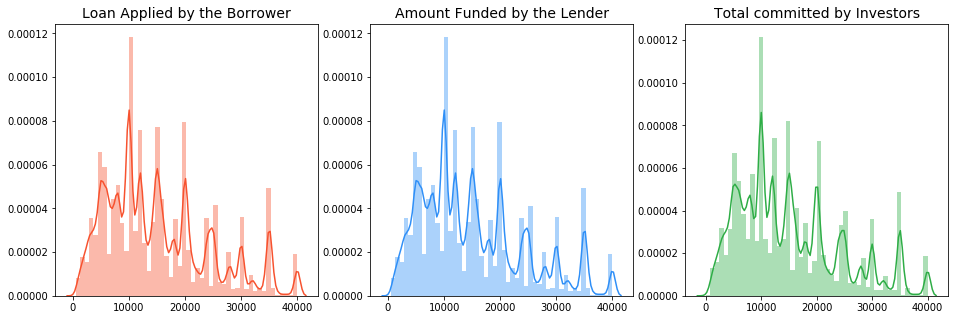

In [17]:
# distribution of loan amount
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = acc["loan_amnt"].values
funded_amount = acc["funded_amnt"].values
investor_funds = acc["funded_amnt_inv"].values


sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14);
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14);
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14);

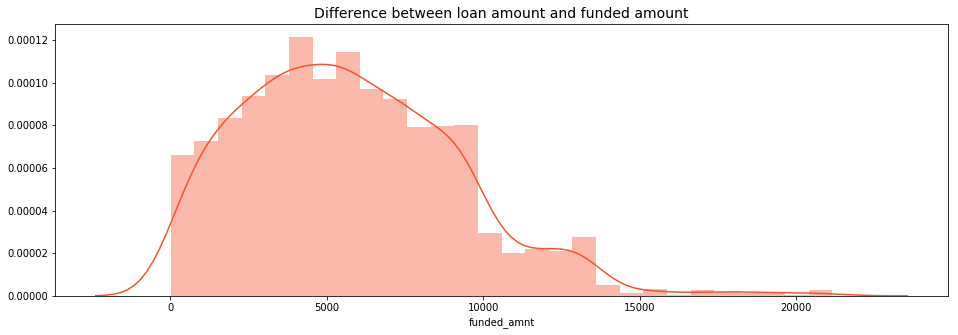

In [18]:
# difference between loan and funded amount
fig, ax = plt.subplots(1, 1, figsize= (16, 5))

amount_diff = acc["loan_amnt"].values - acc["funded_amnt"]
amount_diff = amount_diff[amount_diff > 0]

sns.distplot(amount_diff, ax = ax, color="#F7522F")
ax.set_title("Difference between loan amount and funded amount", fontsize=14);

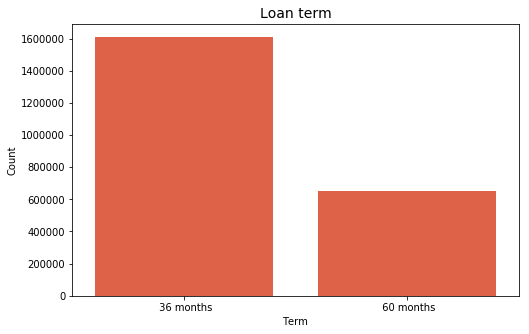

In [46]:
# difference between loan and funded amount
fig, ax = plt.subplots(1, 1, figsize= (8, 5))

# count loans by term
loan_term = acc["term"].value_counts()
loan_term = pd.DataFrame(loan_term).reset_index(drop = False)
loan_term.columns = ["Term", "Count"]

sns.barplot(x = loan_term["Term"], y = loan_term["Count"], ax = ax, color= "#F7522F")
ax.set_title("Loan term", fontsize= 14);

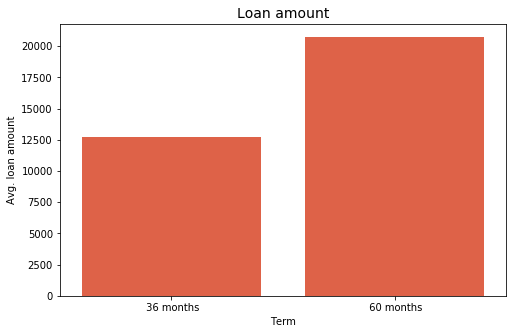

In [51]:
# loan amount by loan term
fig, ax = plt.subplots(1, 1, figsize= (8, 5))

# count loans by term
loan_term = acc.groupby(["term"], as_index = False).agg({"loan_amnt" : "mean"})
loan_term.columns = ["Term", "Avg. loan amount"]

sns.barplot(x = loan_term["Term"], y = loan_term["Avg. loan amount"], ax = ax, color= "#F7522F")
ax.set_title("Loan amount", fontsize= 14);

In [70]:
loan_status

,term,loan_status,num_loans,perc_loans
0,36 months,Charged Off,163252,10.283992
1,36 months,Current,566695,35.698717
5,36 months,Fully Paid,857491,54.017291
9,60 months,Charged Off,105307,16.552785
10,60 months,Current,311622,48.982614
14,60 months,Fully Paid,219260,34.464601


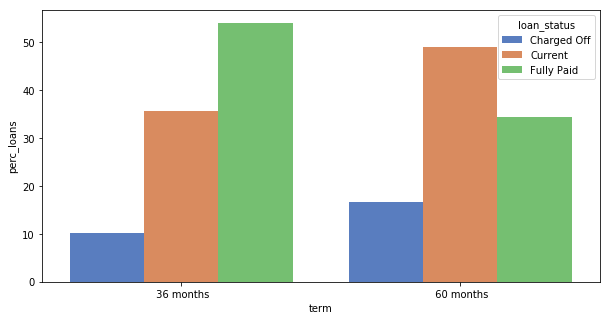

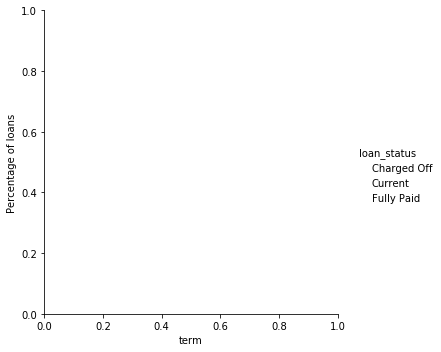

In [85]:
# loan status by loan term
fig, ax = plt.subplots(1, 1, figsize= (10, 5))

# count loans by term
loan_status = acc.groupby(["term", "loan_status"], as_index = False).agg({"id" : "count"})
loan_status.columns = ["term", "loan_status", "num_loans"]
loan_status = loan_status.loc[loan_status["loan_status"].isin(["Fully Paid", "Current", "Charged Off"]), :]
loan_status['perc_loans'] = loan_status[["term", "num_loans"]].apply(lambda x: 100*x["num_loans"]/np.sum(loan_status[loan_status["term"]==x["term"]]["num_loans"]),axis =1)

g = sns.catplot(x = "term", y = "perc_loans", 
            hue = "loan_status", data = loan_status, 
            ax = ax, kind= "bar", palette= "muted")
g.set_ylabels("Percentage of loans");

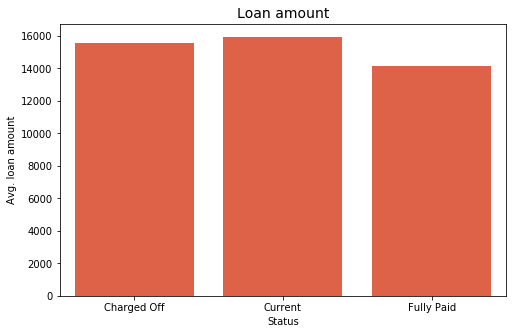

In [91]:
# loan amount by loan status
fig, ax = plt.subplots(1, 1, figsize= (8, 5))

# count loans by term
loan_status = acc.groupby(["loan_status"], as_index = False).agg({"loan_amnt" : "mean"})
loan_status.columns = ["Status", "Avg. loan amount"]
loan_status = loan_status.loc[loan_status["Status"].isin(["Fully Paid", "Current", "Charged Off"]), :]

sns.barplot(x = loan_status["Status"], y = loan_status["Avg. loan amount"], ax = ax, color= "#F7522F")
ax.set_title("Loan amount", fontsize= 14);

----

# 3. Preparing data for modeling

----

### 3.1. Target variable

In [101]:
# We consider only binary classification - fully paid vs. charged off
model_df = acc.loc[acc["loan_status"].isin(["Fully Paid", "Charged Off"]), :]
print(model_df.shape)
print(model_df["loan_status"].value_counts())

(1345310, 151)
Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64


In [102]:
# conver to binary value
model_df["target"] = np.where(model_df["loan_status"] == "Charged Off", 1, 0)
print(model_df["target"].value_counts())

0    1076751
1     268559
Name: target, dtype: int64


----

### 3.2. Independent variables / Covariates / Features

In [136]:
features = ["funded_amnt", "fico_range_low", "annual_inc"]

In [137]:
model_df[features].describe()

,funded_amnt,fico_range_low,annual_inc
count,1.345310e+06,1.345310e+06,1.345310e+06
mean,1.441156e+04,6.961850e+02,7.624764e+04
std,8.713118e+03,3.185251e+01,6.992510e+04
min,5.000000e+02,6.250000e+02,0.000000e+00
25%,8.000000e+03,6.700000e+02,4.578000e+04
50%,1.200000e+04,6.900000e+02,6.500000e+04
75%,2.000000e+04,7.100000e+02,9.000000e+04
max,4.000000e+04,8.450000e+02,1.099920e+07


----

### 3.3. Train/Val/Test split

In [138]:
# =============================
# Train-val-test split
# =============================

train, val = train_test_split(model_df, test_size= 0.5, train_size= 0.5, random_state= 234)
val, test = train_test_split(val, test_size= 0.5, train_size= 0.5, random_state= 675)
print("Train data size: " + str(train.shape))
print("Validation data size: " + str(val.shape))
print("Test data size: " + str(test.shape))

Train data size: (672655, 152)
Validation data size: (336327, 152)
Test data size: (336328, 152)


----

# 4. Logistic regression

In [139]:
log_reg = LogisticRegression(penalty = "none", solver= "saga")
log_reg.fit(train[features], train["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='none', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [140]:
# predict on validation data
log_reg_val = log_reg.predict_proba(val[features])[:,1]  # Probability that model predicts label 1
log_reg_val = pd.Series(log_reg_val)
print(log_reg_val.describe())  # Summary statistics of probabilities across validation set
print(" -- -- -- ")

count    3.363270e+05
mean     2.411447e-01
std      9.730999e-02
min      8.298663e-73
25%      1.745747e-01
50%      2.512144e-01
75%      3.150191e-01
max      5.610818e-01
dtype: float64
 -- -- -- 


In [141]:
# auc score
print("Logistic regression performance: " + str(np.round(roc_auc_score(val["target"], log_reg_val.values), 3)))

Logistic regression performance: 0.558


In [142]:
# variable coefficients
log_reg.coef_

array([[ 6.70743997e-06, -3.39462438e-05, -1.79975988e-05]])

----

# 5. Ridge regression

In [143]:
ridge_reg = LogisticRegression(penalty = "l2", C = 1.0)
ridge_reg.fit(train[features], train["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [144]:
# predict on validation data
ridge_preds_val = ridge_reg.predict_proba(val[features])[:,1]  # Probability that model predicts label 1
ridge_preds_val = pd.Series(ridge_preds_val)
print(ridge_preds_val.describe())  # Summary statistics of probabilities across validation set
print(" -- -- -- ")

count    3.363270e+05
mean     1.983509e-01
std      4.728998e-02
min      2.494483e-25
25%      1.687533e-01
50%      1.952890e-01
75%      2.253977e-01
max      4.972436e-01
dtype: float64
 -- -- -- 


In [145]:
# auc score
print("Ridge regression performance: " + str(np.round(roc_auc_score(val["target"], ridge_preds_val.values), 3)))

Ridge regression performance: 0.615


In [146]:
# variable coefficients
ridge_reg.coef_

array([[ 3.53047484e-05, -2.12419831e-03, -6.03224785e-06]])

----

# 6. LASSO

In [147]:
lasso = LogisticRegression(penalty = "l1", C = 1.0)
lasso.fit(train[features], train["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [148]:
# predict on validation data
lasso_preds_val = lasso.predict_proba(val[features])[:,1]  # Probability that model predicts label 1
lasso_preds_val = pd.Series(lasso_preds_val)
print(lasso_preds_val.describe())  # Summary statistics of probabilities across validation set
print(" -- -- -- ")

count    3.363270e+05
mean     2.003549e-01
std      6.637347e-02
min      8.563254e-26
25%      1.561931e-01
50%      2.018172e-01
75%      2.439550e-01
max      5.621253e-01
dtype: float64
 -- -- -- 


In [149]:
# auc score
print("LASSO performance: " + str(np.round(roc_auc_score(val["target"], lasso_preds_val.values), 3)))

LASSO performance: 0.635


In [150]:
# variable coefficients
lasso.coef_

array([[ 3.68878627e-05, -1.09510916e-02, -6.17633219e-06]])